## Importación de Librerías y Carga y Preprocesamiento de Datos de Tráfico de Red

**1. Carga de Datos desde SQLite:**

Se define una función load_data_from_db que carga datos desde una base de datos SQLite y devuelve un DataFrame de pandas.

**2. Añadir una Columna timestamp Sintética:**

Se añade una columna timestamp sintética al DataFrame utilizando un rango de fechas.

**3. Mostrar las Primeras Filas de los Datos:**

Se imprimen las primeras filas del DataFrame para verificar la carga y la adición de la columna timestamp.

**4. Función Mejorada para Preprocesar los Datos:**

* Se define una función preprocess_data que realiza varias tareas de preprocesamiento:
    - Convierte direcciones IP a enteros mediante una función interna ip_to_int.
    - Extrae características relevantes como el tamaño del paquete (packet_size) y el intervalo de tiempo (time_interval).
    - Selecciona solo las columnas numéricas para el preprocesamiento.
    - Llena los valores faltantes con la mediana de las columnas numéricas.
    - Normaliza los datos usando StandardScaler de scikit-learn.

**5. Preprocesamiento de los Datos:**

Se preprocesan los datos llamando a la función preprocess_data y se almacena el resultado en df_preprocessed.

**6. Visualización de la Distribución de los Datos Preprocesados:**

Se visualiza la distribución de los datos preprocesados usando gráficos de pares (pairplot) de Seaborn.

  protocol         src_addr  src_port         dst_addr  dst_port  \
0      TCP  162.159.133.234       443     192.168.1.11     38048   
1      TCP     192.168.1.11     38048  162.159.133.234       443   
2      TCP    140.82.113.25       443     192.168.1.11     48930   
3      TCP     192.168.1.11     48930    140.82.113.25       443   
4      TCP    140.82.113.25       443     192.168.1.11     48930   

            timestamp  
0 2023-01-01 00:00:00  
1 2023-01-01 00:00:01  
2 2023-01-01 00:00:02  
3 2023-01-01 00:00:03  
4 2023-01-01 00:00:04  


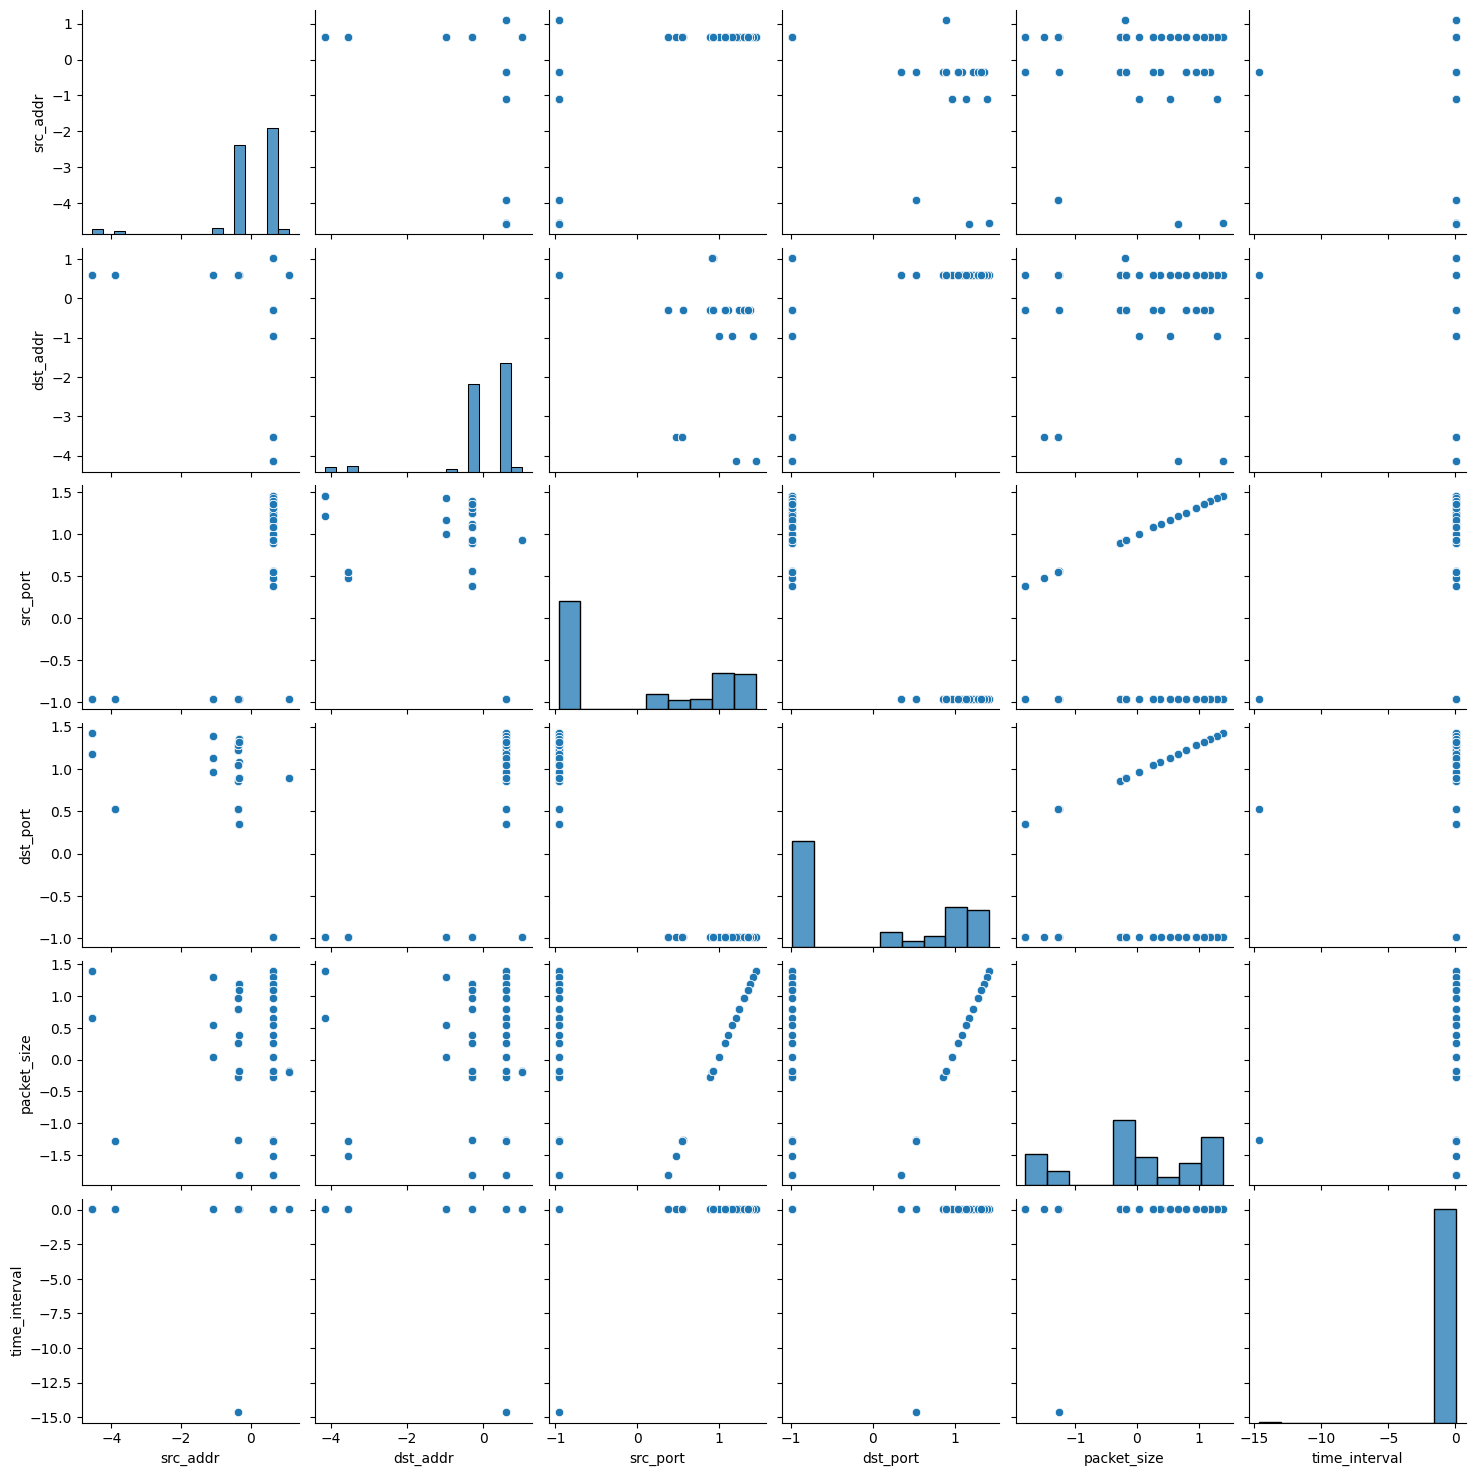

In [1]:
import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos desde SQLite
def load_data_from_db(db_name='network_traffic.db', table_name='traffic'):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

df_packets = load_data_from_db()

# Añadir una columna `timestamp` sintética
df_packets['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df_packets), freq='s')

# Mostrar las primeras filas de los datos cargados con la columna `timestamp`
print(df_packets.head())

# Función mejorada para preprocesar los datos
def preprocess_data(df):
    # Convertir direcciones IP a enteros
    def ip_to_int(ip):
        try:
            return int(''.join(f'{int(i):08b}' for i in ip.split('.')), 2)
        except:
            return 0

    df['src_addr'] = df['src_addr'].apply(ip_to_int)
    df['dst_addr'] = df['dst_addr'].apply(ip_to_int)

    # Extraer características relevantes
    df['packet_size'] = df['src_port'] + df['dst_port']
    df['time_interval'] = df['timestamp'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds()

    # Seleccionar solo las columnas numéricas
    numeric_columns = ['src_addr', 'dst_addr', 'src_port', 'dst_port', 'packet_size', 'time_interval']

    # Llenar valores faltantes con la mediana
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    # Normalizar los datos
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[numeric_columns])

    return df_scaled

df_preprocessed = preprocess_data(df_packets)

# Visualizar la distribución de los datos preprocesados
sns.pairplot(pd.DataFrame(df_preprocessed, columns=['src_addr', 'dst_addr', 'src_port', 'dst_port', 'packet_size', 'time_interval']))
plt.show()

## Evaluación del Modelo Isolation Forest para Detección de Anomalías

**1. Generación de Datos de Entrenamiento con Anomalías:**

Se generan 2000 ejemplos de anomalías sintéticas y se combinan con los datos normales para crear un conjunto de entrenamiento que incluye tanto datos normales como anomalías.

**2. Definición de Parámetros para GridSearchCV:**

Se define una cuadrícula de parámetros (param_grid) que será utilizada para ajustar el modelo de Isolation Forest. Los parámetros incluyen n_estimators, max_samples, contamination y max_features.

**3. Creación del Modelo de Isolation Forest:**

Se crea una instancia del modelo de Isolation Forest (if_model).

**4. Función de Puntuación Personalizada:**

Se define una función de puntuación personalizada (scorer) que utiliza el puntaje F1 con promedio macro.

**5. Ajuste de Hiperparámetros con GridSearchCV:**

Se utiliza GridSearchCV para ajustar los hiperparámetros del modelo de Isolation Forest utilizando la cuadrícula de parámetros definida y la función de puntuación personalizada. El modelo se entrena solo con datos normales.

**6. Obtención del Mejor Modelo:**

Se obtiene el mejor modelo (best_if_model) encontrado por GridSearchCV.

**7. Función para Evaluar el Modelo:**

Se define una función (evaluate_model) que evalúa el modelo utilizando datos de prueba y calcula las métricas de precisión, recall, puntaje F1 y exactitud.

**8. Generación de Datos de Prueba:**

Se generan datos de prueba que incluyen tanto datos normales como anomalías sintéticas.

**9. Evaluación del Modelo Isolation Forest:**

Se evalúa el mejor modelo de Isolation Forest utilizando los datos de prueba y se calculan las métricas de rendimiento.

**10. Visualización de Resultados:**

Se almacenan y visualizan las métricas de rendimiento en un gráfico de barras.

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Resultados de Isolation Forest
      Metric     Score
0  Precision  0.791133
1     Recall  0.670556
2   F1 Score  0.640845
3   Accuracy  0.682692


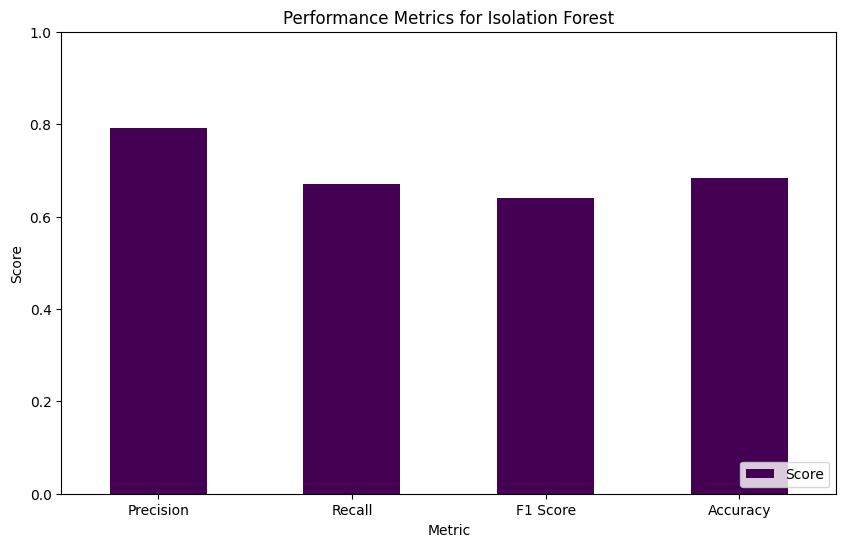

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Aumentar la proporción de anomalías en los datos de entrenamiento
anomalies_train = np.random.uniform(low=-10, high=10, size=(2000, df_preprocessed.shape[1]))  # Generar 2000 ejemplos de anomalías
X_train_with_anomalies = np.vstack([df_preprocessed, anomalies_train])
y_train_with_anomalies = [0] * len(df_preprocessed) + [1] * 2000

# Definir los parámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.6, 0.8],
    'contamination': [0.02, 0.05, 0.1],
    'max_features': [1.0, 0.8, 0.6]
}

# Crear el modelo de Isolation Forest
if_model = IsolationForest()

# Custom scoring function to use F1 score with macro average
scorer = make_scorer(f1_score, average='macro')

# GridSearchCV para el ajuste de hiperparámetros
gs = GridSearchCV(if_model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
gs.fit(df_preprocessed, [0] * len(df_preprocessed))  # Entrenar solo con datos normales

# Obtener el mejor modelo
best_if_model = gs.best_estimator_

# Función para evaluar el modelo y obtener métricas
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
    accuracy = accuracy_score(y_test, y_pred)
    return precision, recall, f1, accuracy

# Generar datos de prueba incluyendo anomalías sintéticas
X_test_normal = df_preprocessed
y_test_normal = [0] * len(X_test_normal)

# Crear anomalías sintéticas (por ejemplo, valores fuera del rango normal)
anomalies = np.random.uniform(low=-10, high=10, size=(200, X_test_normal.shape[1]))
X_test_anomalies = np.vstack([X_test_normal, anomalies])
y_test_anomalies = y_test_normal + [1] * 200

# Evaluar y almacenar resultados de Isolation Forest
precision_if, recall_if, f1_if, accuracy_if = evaluate_model(best_if_model, X_test_anomalies, y_test_anomalies)

# Visualizar los resultados de Isolation Forest
results_if = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [precision_if, recall_if, f1_if, accuracy_if]
})

print("Resultados de Isolation Forest")
print(results_if)

# Graficar los resultados de Isolation Forest
results_if.set_index('Metric').plot(kind='bar', figsize=(10, 6), ylim=(0, 1), colormap='viridis')
plt.title('Performance Metrics for Isolation Forest')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


## Evaluación del Modelo One-Class SVM para Detección de Anomalías

**1. Entrena un modelo One-Class SVM para la detección de anomalías utilizando GridSearchCV para ajustar los hiperparámetros (nu, kernel, y gamma).**

**2. Evalúa el modelo One-Class SVM ajustado con datos de prueba que incluyen anomalías sintéticas, calculando métricas de rendimiento como precisión, recall, F1 score y exactitud.**

**3. Visualiza los resultados mediante un gráfico de barras que muestra las métricas de rendimiento del modelo One-Class SVM.**

Estas acciones permiten ajustar y evaluar el modelo One-Class SVM en términos de su capacidad para identificar anomalías en un conjunto de datos específico.

Resultados de One-Class SVM
      Metric  Score
0  Precision    1.0
1     Recall    1.0
2   F1 Score    1.0
3   Accuracy    1.0


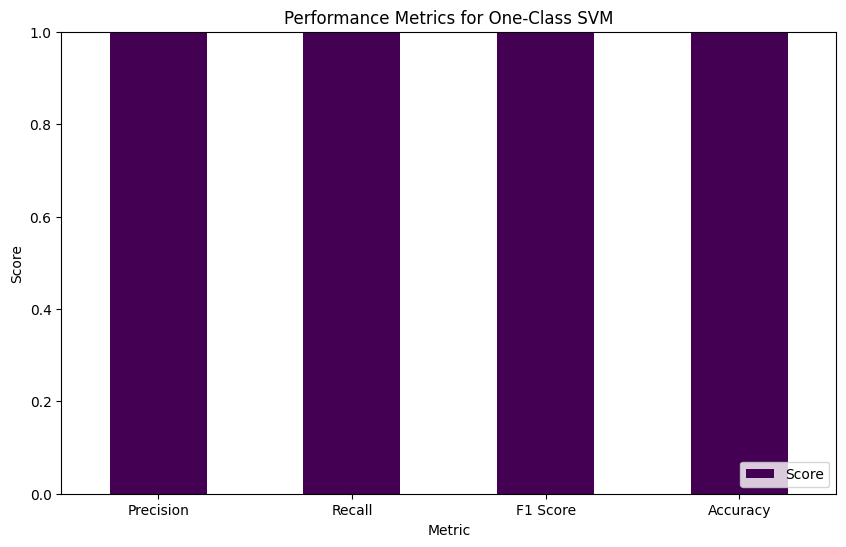

In [3]:
from sklearn.svm import OneClassSVM

# Entrenamiento de One-Class SVM con GridSearchCV para ajustar hiperparámetros
param_grid_svm = {'nu': [0.05, 0.1, 0.15], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
grid_search_svm = GridSearchCV(OneClassSVM(), param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_with_anomalies, y_train_with_anomalies)
best_svm_model = grid_search_svm.best_estimator_

# Evaluar y almacenar resultados de One-Class SVM
precision_svm, recall_svm, f1_svm, accuracy_svm = evaluate_model(best_svm_model, X_test_anomalies, y_test_anomalies)

# Visualizar los resultados de One-Class SVM
results_svm = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [precision_svm, recall_svm, f1_svm, accuracy_svm]
})

print("Resultados de One-Class SVM")
print(results_svm)

# Graficar los resultados de One-Class SVM
results_svm.set_index('Metric').plot(kind='bar', figsize=(10, 6), ylim=(0, 1), colormap='viridis')
plt.title('Performance Metrics for One-Class SVM')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()
